In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import mean_absolute_error,accuracy_score,classification_report,precision_recall_fscore_support, confusion_matrix,r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns



## Data reading

In [112]:
data = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
data.head()    


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
print(data.shape)  
print(data.dtypes)

(16719, 16)
Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Developer           object
Rating              object
dtype: object


In [114]:

numerical_columns = data.select_dtypes('float64').columns
categorical_columns = data.select_dtypes('object').columns
print(numerical_columns)


Index(['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
       'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score',
       'User_Count'],
      dtype='object')


### Üresek eltávolítása

In [120]:
cols_to_replace = ['Publisher', 'Developer','Name']
for column in cols_to_replace:
    data[column].fillna('Unknown', inplace=True)

In [119]:
#regi jatekok altalaban nem ertekeltek
data['Critic_Count'] = data['Critic_Count'].fillna(1)
data['User_Count'] = data['User_Count'].fillna(1)

In [118]:
from sklearn.impute import KNNImputer
columns_with_missing = ['User_Score', 'Critic_Score','Year_of_Release']
imputer = KNNImputer(n_neighbors=5)
data[columns_with_missing] = imputer.fit_transform(data[columns_with_missing])

In [128]:
#lehet hogy nagyon rossz ötlet
#helyette
#data.dropna(subset=['Genre'], inplace=True)
for index, row in data.iterrows():
    year = row['Year_of_Release']
    genre = row['Genre']
    if pd.isnull(row['Rating']):
        if year >= 2010 and genre in ['Action', 'Adventure']:
            data.at[index, 'Rating'] = 'T'
        elif year < 2010 and genre in ['Action', 'Adventure']:
            data.at[index, 'Rating'] = 'M'
        elif genre in ['Sports', 'Racing']:
            data.at[index, 'Rating'] = 'E'
        else:
            data.at[index, 'Rating'] = 'E10+'


In [126]:
data.dropna(subset=['Genre'], inplace=True)

In [129]:
print(data.isnull().sum())
print(data.shape)

Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
Critic_Count       0
User_Score         0
User_Count         0
Developer          0
Rating             0
dtype: int64
(16717, 16)


In [130]:

data['Year_of_Release'] = data['Year_of_Release'].astype(int)
data['User_Count'] = data['User_Count'].astype(int)
data['Critic_Count'] = data['Critic_Count'].astype(int)
data['Critic_Score'] = data['Critic_Score'].astype(int)

data['User_Score'] = (data['User_Score'] * 10).astype(int)

columns_to_convert = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
data[columns_to_convert] = (data[columns_to_convert] * 100).astype(int)


In [131]:
data[numerical_columns]

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
0,2006,4136,2896,377,844,8253,76,51,80,322
1,1985,2908,358,681,77,4024,73,1,59,1
2,2008,1568,1276,379,329,3552,82,73,83,709
3,2009,1561,1093,328,295,3277,80,73,80,192
4,1996,1127,889,1022,100,3137,91,1,84,1
...,...,...,...,...,...,...,...,...,...,...
16714,2016,0,0,1,0,1,62,1,75,1
16715,2006,0,1,0,0,1,67,1,71,1
16716,2016,0,0,1,0,1,62,1,75,1
16717,2003,1,0,0,0,1,77,1,75,1


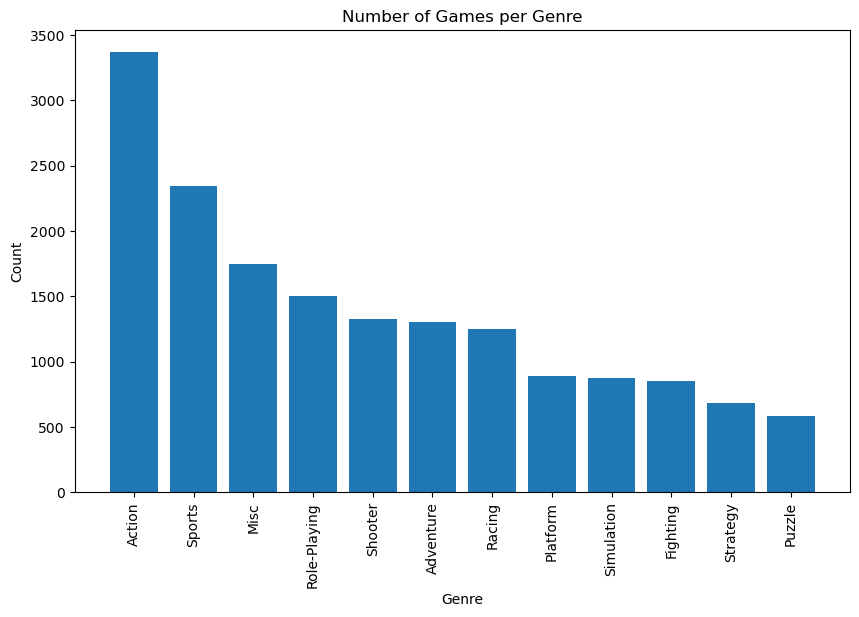

In [132]:
genre_counts = data['Genre'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of Games per Genre')
plt.xticks(rotation=90)
plt.show()

In [133]:
##Name nem kell mert egyéni érték 
data = data.drop(['Name'],axis=1)

## LabelEncoding, Splittin

In [3]:
label_encoders = {}

for column in categorical_columns:
    label_encoder = LabelEncoder()

    encoded_values = label_encoder.fit_transform(data[column].astype(str))
    label_encoders[column] = label_encoder
    data[column] = encoded_values
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)

## Correlation matrix

C:\Users\jooda\AppData\Local\Temp\ipykernel_17964\507920283.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()             # Calculate the correlation matrix


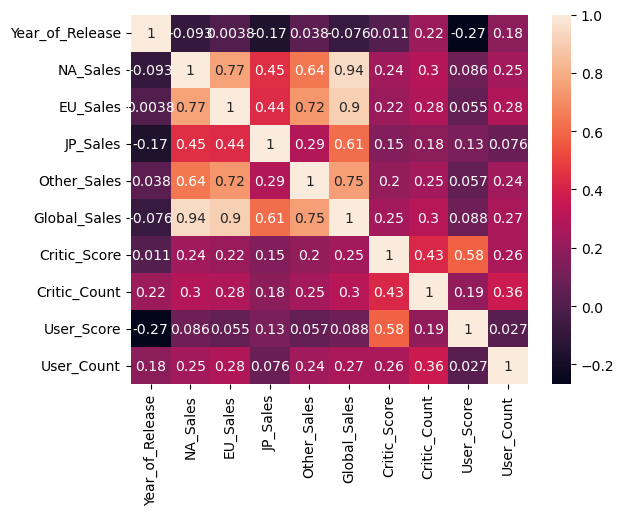

In [38]:
corr_matrix = data.corr()             # Calculate the correlation matrix
sns.heatmap(corr_matrix, annot=True)  # Plot the correlation matrix as a heatmap
plt.show()                            # Show the plot


## RandomForest
### Feature 
### HyperParameter

In [21]:


X_rf = X
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=420)
rf_classifier = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 300)
rf_classifier.fit(X_train,y=y_train)
y_pred = rf_classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)
X_test

0.5700598802395209
MAE: 2.223952095808383


,Platform,Year_of_Release,Publisher,NA_Sales,EU_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
275,7,2003,101,88,229,420,80,32,75,22,617,1
4640,8,2010,28,27,9,42,58,47,62,28,539,5
2600,9,2015,61,13,42,79,87,54,71,680,382,1
7572,14,2008,126,16,2,20,52,27,70,48,755,4
4589,14,2009,5,23,15,42,71,56,59,18,77,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3438,7,2004,30,49,2,57,73,35,82,60,215,5
7513,8,2006,77,6,0,20,33,31,51,47,76,5
2162,4,2003,115,74,19,95,71,10,86,34,313,1
5094,14,2009,30,12,21,37,66,19,64,9,208,1


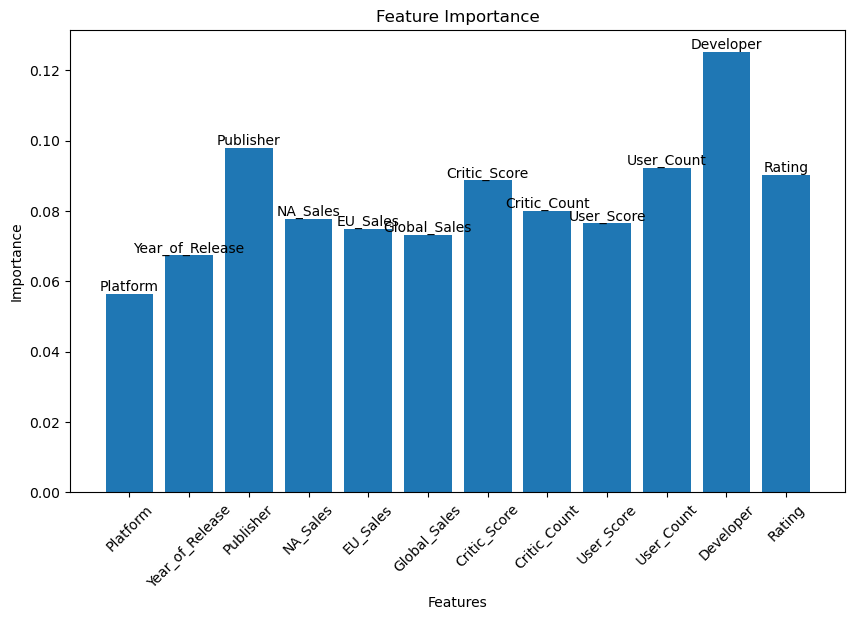

In [60]:

importance_values = rf_classifier.feature_importances_
feature_names = X_rf.columns

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(feature_names)), importance_values)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(range(len(feature_names)), feature_names, rotation=45)  


for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, feature_names[i], ha='center', va='bottom')

plt.show()


In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_rf_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('Accuracy: ',accuracy_score(y_test, y_pred))


## SVM

In [22]:
svm = SVC(C= 10, gamma= 0.1, kernel= 'rbf')
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

0.23353293413173654
MAE: 5.292215568862275


In [180]:

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}


svm_classifier = SVC()


grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


In [1]:

svm = SVC(**best_params)
svm.fit(X_train, y_train)


y_pred = svm.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('Accuracy: ',accuracy_score(y_test,y_pred))

NameError: name 'SVC' is not defined

## LogisticRegression 

In [23]:
X_lr = X
X_train, X_test, y_train, y_test = train_test_split(X_lr, y, test_size=0.2, random_state=420)
lr = LogisticRegression(C= 10, penalty= 'l2',solver= 'liblinear')
lr.fit(X_train,y_train)

st_x= StandardScaler()  
X_train= st_x.fit_transform(X_train)  
X_test= st_x.transform(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)


Accuracy: 0.23353293413173654
MAE: 5.292215568862275


In [66]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

logistic_classifier = LogisticRegression()

grid_search = GridSearchCV(logistic_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-pack

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [68]:
best_logistic_classifier = LogisticRegression(**best_params)
best_logistic_classifier.fit(X_train, y_train)

y_pred = best_logistic_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.72      0.47       349
           1       0.00      0.00      0.00        51
           2       0.22      0.03      0.05        67
           3       0.00      0.00      0.00        84
           4       0.16      0.10      0.13        78
           5       0.43      0.12      0.18        26
           6       0.14      0.02      0.03       125
           7       0.34      0.18      0.24       137
           8       0.22      0.17      0.19       155
           9       0.00      0.00      0.00        62
          10       0.39      0.74      0.51       183
          11       0.29      0.10      0.15        48

    accuracy                           0.34      1365
   macro avg       0.21      0.18      0.16      1365
weighted avg       0.25      0.34      0.26      1365

0.3362637362637363


c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



In [10]:
def create_model(hidden_units=64, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_dim=input_dim))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [150]:
fnn_model = KerasClassifier(build_fn=create_model)

# Define the parameter grid for grid search
param_grid = {
    'hidden_units': [64, 128, 256],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50,100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=fnn_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

Epoch 1/50


C:\Users\jooda\AppData\Local\Temp\ipykernel_20340\2331746403.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  fnn_model = KerasClassifier(build_fn=create_model)


70/70 [==============================] - 2s 1ms/step - loss: 50.1809 - accuracy: 0.1556
Epoch 2/50
70/70 [==============================] - 0s 2ms/step - loss: 12.5887 - accuracy: 0.1592
Epoch 3/50
70/70 [==============================] - 0s 1ms/step - loss: 9.3607 - accuracy: 0.1668
Epoch 4/50
70/70 [==============================] - 0s 1ms/step - loss: 9.7197 - accuracy: 0.1713
Epoch 5/50
70/70 [==============================] - 0s 1ms/step - loss: 9.5893 - accuracy: 0.1731
Epoch 6/50
70/70 [==============================] - 0s 1ms/step - loss: 6.8275 - accuracy: 0.1911
Epoch 7/50
70/70 [==============================] - 0s 1ms/step - loss: 8.6142 - accuracy: 0.1785
Epoch 8/50
70/70 [==============================] - 0s 1ms/step - loss: 7.0574 - accuracy: 0.1808
Epoch 9/50
70/70 [==============================] - 0s 1ms/step - loss: 7.6486 - accuracy: 0.1803
Epoch 10/50
70/70 [==============================] - 0s 1ms/step - loss: 7.5427 - accuracy: 0.1875
Epoch 11/50
70/70 [=========

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000016C14F8EF50>,
             param_grid={'epochs': [50, 100], 'hidden_units': [64, 128, 256],
                         'learning_rate': [0.001, 0.01, 0.1]},
             scoring='accuracy')

In [151]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

test_accuracy = best_model.score(X_test, y_test)

print("Best hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)

27/27 [==============================] - 0s 1ms/step - loss: 1.9771 - accuracy: 0.3629
Best hyperparameters: {'epochs': 100, 'hidden_units': 256, 'learning_rate': 0.01}
Test Accuracy: 0.36287423968315125


## Voting

In [11]:

rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 300)
lr = LogisticRegression(C= 10, penalty= 'l2',solver= 'liblinear')
svc = SVC(C= 10, gamma= 0.1, kernel= 'rbf')



voting_classifier = VotingClassifier(
    estimators=[('svc', svc), ('rf', rf), ('lr', lr)],
    voting='hard'
)

voting_classifier.fit(X_train, y_train)

y_pred = voting_classifier.predict(X_test)
y_pred = voting_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

with open('voting_classifier.pkl', 'wb') as f:
    pickle.dump(voting_classifier, f)

Accuracy: 0.49820359281437127
MAE: 2.8419161676646705


## Stacking

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 300)
lr = LogisticRegression(C= 10, penalty= 'l2',solver= 'liblinear',max_iter=1000)
svc = SVC(C= 10, gamma= 0.1, kernel= 'rbf',max_iter=1000)
fnn = MLPClassifier(hidden_layer_sizes=(256,), activation='relu', max_iter=1000)

stacking_classifier = StackingClassifier(
    estimators=[('svc', svc), ('rf', rf), ('lr', lr)],
    final_estimator=fnn
)

stacking_classifier.fit(X_train, y_train)

y_pred = stacking_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_classifier, f)

c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\svm\_base.py:

Accuracy: 0.5173652694610779
